
# Variational Quantum Classifier (VQC) with SPSA (3 Qubits)

This notebook trains a **Variational Quantum Classifier (VQC)** on your **PCA(3)** features using:

- **Angle encoding**: one qubit per feature (3 qubits total), `RY` rotations  
- A shallow **ansatz**: per-qubit trainable rotations + ring CNOT entanglement  
- **SPSA** optimizer: robust, 2 circuit evaluations per iteration  
- **One-vs-Rest** multi-class strategy for 5 emotions (angry, fearful, happy, neutral, sad)

**Inputs (from Step 3)**  
`../data/processed/pca3_train.csv` and `../data/processed/pca3_test.csv`

**Outputs**  
- Trained parameters for each class under `../data/processed/vqc_models_spsa/<class>/params.npz`  
- Angle scaling used at train time in `../data/processed/vqc_models_spsa/angle_scales.json`  
- Metrics on the test split and plots of training loss per class

> If you get **file not found**, set `BASE_DATA` in the config cell to your absolute path, e.g.  
> `BASE_DATA = Path("/Users/you/Documents/project/thesis_code/data")`.


## Install (run if needed)

In [18]:

# %pip install pennylane pandas numpy scikit-learn matplotlib


## Config (paths, labels, hyperparameters)

In [19]:

from pathlib import Path

# 📁 Place this notebook in thesis_code/notebooks/
BASE_DATA = Path("/Users/nishchalpokhrel/Documents/project/thesis_code/data")   # change to absolute if needed
# Example absolute path for your setup:
# BASE_DATA = Path("/Users/nishchalpokhrel/Documents/project/thesis_code/data")

PROCESSED_DIR = BASE_DATA / "processed"

# Inputs (from Step 3)
TRAIN_CSV = PROCESSED_DIR / "pca3_train.csv"
TEST_CSV  = PROCESSED_DIR / "pca3_test.csv"

# Pick which PC columns to use (length = #qubits)
PC_COLS = ["PC1","PC2","PC3"]            # adjust to match the file
N_QUBITS = len(PC_COLS)


# Emotion classes (must match Step 1/2 pipeline)
ALL_CLASSES = ["angry", "fearful", "happy", "neutral", "sad"]

# Quantum & training settings
LAYERS = 2                # 1–2 layers recommended for small data
MAX_ITERS = 150           # SPSA iterations per class
BATCH_SIZE = 64           # set None for full-batch
SEED = 7


# SPSA hyperparameters
SPSA_STEPSIZE = 0.1       # 'a' learning-rate scale
SPSA_PERTURB  = 0.1       # 'c' perturbation scale
LOG_EVERY = 10            # print loss every N iters

# Angle scaling: map each PC to [-π, π] based on max-abs of TRAIN
ANGLE_CLIP = 3.141592653589793

# Output directory
OUT_DIR = PROCESSED_DIR / "vqc_models_spsa"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("TRAIN_CSV:", TRAIN_CSV.resolve())
print("TEST_CSV :", TEST_CSV.resolve())


TRAIN_CSV: /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/pca3_train.csv
TEST_CSV : /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/pca3_test.csv


## Debug — verify Step 3 outputs exist

In [20]:

missing = []
if not TRAIN_CSV.exists(): missing.append(str(TRAIN_CSV))
if not TEST_CSV.exists():  missing.append(str(TEST_CSV))
if missing:
    raise SystemExit(
        "⚠️ Missing required files:\n  - " + "\n  - ".join(missing) +
        "\nFix BASE_DATA or run Step 3 to create pca3_train/test.csv"
    )
else:
    print("PCA files found ✓")


PCA files found ✓


In [21]:
import pennylane
# print('adsad')

## Imports & Utilities

In [22]:

import json, math, random
import numpy as onp
import pandas as pd
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Reproducibility
pnp.random.seed(SEED); random.seed(SEED); onp.random.seed(SEED)

def load_data(train_csv, test_csv, valid_classes):
    train = pd.read_csv(train_csv)
    test  = pd.read_csv(test_csv)
    # keep only the classes we expect
    train = train[train["emotion"].isin(valid_classes)].reset_index(drop=True)
    test  = test[test["emotion"].isin(valid_classes)].reset_index(drop=True)
    # verify columns
    for col in ["PC1","PC2","PC3","emotion"]:
        assert col in train.columns and col in test.columns, f"Missing column {col}"
    return train, test

def build_angle_scaler(train_df, clip=math.pi):
    """Map each PC to [-clip, clip] using max-abs on TRAIN (with 10% margin)."""
    scales = {}
    for k in PC_COLS:
        m = float(train_df[k].abs().max())
        denom = max(1e-8, 1.1*m)  # margin and avoid /0
        scales[k] = {"denom": denom, "clip": clip}
    return scales

def apply_angle_scaler(df, scales):
    X = df[PC_COLS].to_numpy(onp.float32)
    for j, key in enumerate(PC_COLS):
        denom = scales[key]["denom"]; clip = scales[key]["clip"]
        X[:, j] = np.clip((X[:, j] / denom) * clip, -clip, clip)
    return X  # shape (N,3)

def one_vs_rest_labels(df, positive_class):
    return (df["emotion"].values == positive_class).astype(onp.float32)

def batches(X, y, batch_size):
    if batch_size is None or batch_size >= len(X):
        yield X, y
    else:
        idx = onp.arange(len(X)); onp.random.shuffle(idx)
        for start in range(0, len(X), batch_size):
            sl = idx[start:start+batch_size]
            yield X[sl], y[sl]


## Quantum Model — 3-qubit angle encoding + shallow ansatz

In [23]:

# For shot noise, set shots=1024. For analytic expectation, leave shots=None.
dev = qml.device("default.qubit", wires=N_QUBITS, shots=None)

def encode_angles(angles):
    """Angle encoding: RY(θ_i) on qubit i for θ derived from PC_i."""
    for i, ang in enumerate(angles):
        qml.RY(ang, wires=i)

def ansatz(theta):
    """LAYERS of per-qubit rotations (RY,RZ) + ring CNOT entanglement."""
    # theta shape: (LAYERS, N_QUBITS, 2)
    for l in range(theta.shape[0]):
        for q in range(N_QUBITS):
            qml.RY(theta[l, q, 0], wires=q)
            qml.RZ(theta[l, q, 1], wires=q)
        # ring entanglement 0→1, 1→2, 2→0
        qml.CNOT(wires=[0,1]); qml.CNOT(wires=[1,2]); qml.CNOT(wires=[2,0])

@qml.qnode(dev)
def vqc_qnode(angles, theta):
    encode_angles(angles)
    ansatz(theta)
    return qml.expval(qml.PauliZ(0))  # scalar in [-1,1]

def sigmoid(x): return 1.0/(1.0+np.exp(-x))


## Parameters, forward pass, and loss

In [24]:

# We optimize both the quantum params 'theta' and a small classical head (w, b):
# prob = sigmoid( w * expval + b )
THETA_SIZE = LAYERS * N_QUBITS * 2

def unpack_params(params):
    theta_flat = params[:THETA_SIZE]
    w = params[THETA_SIZE]
    b = params[THETA_SIZE+1]
    theta = theta_flat.reshape((LAYERS, N_QUBITS, 2))
    return theta, w, b

def init_params(scale=0.1):
    theta0 = pnp.random.uniform(-scale, scale, size=(LAYERS, N_QUBITS, 2))
    w0 = pnp.array(0.0); b0 = pnp.array(0.0)
    return pnp.concatenate([theta0.ravel(), pnp.array([w0, b0])])

def predict_probs(params, X):
    theta, w, b = unpack_params(params)
    outs = []
    for i in range(X.shape[0]):
        ev = vqc_qnode(X[i], theta)  # expectation in [-1,1]
        logit = w * ev + b
        outs.append(sigmoid(logit))
    return pnp.array(outs, dtype=pnp.float64)

def bce_loss(params, X, y):
    p = predict_probs(params, X)
    eps = 1e-9
    return -pnp.mean(y*pnp.log(p+eps) + (1-y)*pnp.log(1-p+eps))


## Train one-vs-rest binary VQC with SPSA

In [25]:

# ---- Pure-Python SPSA (version-agnostic) ----
import numpy as np

def _spsa_schedule(k, a0=0.1, c0=0.1, A=None, alpha=0.602, gamma=0.101, max_iters=150):
    """Spall schedule: a_k and c_k decay with iteration k (1-based)."""
    if A is None:
        A = 0.1 * max_iters
    ak = a0 / ((k + A) ** alpha)
    ck = c0 / (k ** gamma)
    return ak, ck

def train_binary_spsa(
    X, y,
    max_iters=150,
    batch_size=64,
    stepsize=0.1,   # initial 'a'
    perturb=0.1,    # initial 'c'
    log_every=10,
    resamplings=1,
    seed=7,
):
    """
    Version-agnostic SPSA for our VQC.
    Uses 2*resamplings circuit evals per iteration, regardless of #params.
    """
    rng = np.random.default_rng(seed)
    n_params = THETA_SIZE + 2  # quantum theta + (w, b)
    params = rng.uniform(-0.1, 0.1, size=n_params).astype(np.float64)

    best_loss = float("inf")
    best_params = params.copy()
    losses = []

    def get_batch():
        if batch_size is None or batch_size >= len(X):
            return X, y
        idx = rng.permutation(len(X))[:batch_size]
        return X[idx], y[idx]

    for it in range(1, max_iters + 1):
        Xb, yb = get_batch()

        # Spall schedule
        a_k, c_k = _spsa_schedule(it, a0=stepsize, c0=perturb, max_iters=max_iters)

        # SPSA gradient estimate
        ghat = np.zeros_like(params, dtype=np.float64)
        for _ in range(resamplings):
            delta = rng.choice([-1.0, 1.0], size=n_params).astype(np.float64)
            p_plus  = params + c_k * delta
            p_minus = params - c_k * delta

            L_plus  = float(bce_loss(p_plus,  Xb, yb))
            L_minus = float(bce_loss(p_minus, Xb, yb))

            ghat += ((L_plus - L_minus) / (2.0 * c_k)) * delta

        ghat /= float(resamplings)

        # Update
        params = params - a_k * ghat

        # Track loss
        curr_loss = float(bce_loss(params, Xb, yb))
        losses.append(curr_loss)
        if curr_loss < best_loss - 1e-9:
            best_loss = curr_loss
            best_params = params.copy()

        if it % log_every == 0:
            print(f"iter {it:04d} | loss {curr_loss:.4f} | best {best_loss:.4f} | a_k={a_k:.4g} c_k={c_k:.4g}")

    return best_params, np.array(losses, dtype=np.float64)


## Load data, scale to angles, and train 1-vs-rest VQCs

In [26]:

# Load splits
train_df, test_df = load_data(TRAIN_CSV, TEST_CSV, ALL_CLASSES)

# Build angle scaling using TRAIN only
angle_scales = build_angle_scaler(train_df, clip=ANGLE_CLIP)

# Apply to both splits
X_train = apply_angle_scaler(train_df, angle_scales)
X_test  = apply_angle_scaler(test_df, angle_scales)

results = {}
for cls in ALL_CLASSES:
    print("\n=== Training one-vs-rest for:", cls, "===")
    y_train = one_vs_rest_labels(train_df, cls)
    y_test  = one_vs_rest_labels(test_df, cls)

    params, losses = train_binary_spsa(
        X_train, y_train,
        max_iters=MAX_ITERS, batch_size=BATCH_SIZE,
        stepsize=SPSA_STEPSIZE, perturb=SPSA_PERTURB, log_every=LOG_EVERY
    )

    # Evaluate
    def probs(params, X):
        theta, w, b = unpack_params(params)
        out = []
        for i in range(X.shape[0]):
            ev = vqc_qnode(X[i], theta)
            out.append(float(1/(1+np.exp(-(w*ev+b)))))
        return onp.array(out, dtype=onp.float64)

    p_tr = probs(params, X_train); p_te = probs(params, X_test)
    yhat_tr = (p_tr >= 0.5).astype(int); yhat_te = (p_te >= 0.5).astype(int)

    # AUROC guard for degenerate labels
    def safe_auc(y_true, s):
        try: return roc_auc_score(y_true, s)
        except Exception: return onp.nan

    acc_tr = accuracy_score(y_train, yhat_tr)
    acc_te = accuracy_score(y_test,  yhat_te)
    auc_tr = safe_auc(y_train, p_tr); auc_te = safe_auc(y_test,  p_te)
    print(f"[{cls}] train acc={acc_tr:.3f} auc={auc_tr:.3f} | test acc={acc_te:.3f} auc={auc_te:.3f}")

    # Save params & losses
    import numpy as np
    cls_dir = OUT_DIR / cls; cls_dir.mkdir(parents=True, exist_ok=True)
    theta, w, b = unpack_params(params)
    np.savez(cls_dir / "params.npz",
             theta=np.asarray(theta), w=float(w), b=float(b),
             layers=LAYERS, n_qubits=N_QUBITS)
    np.savetxt(cls_dir / "losses.txt", losses)

    results[cls] = {"train_acc": float(acc_tr), "test_acc": float(acc_te),
                    "train_auc": None if onp.isnan(auc_tr) else float(auc_tr),
                    "test_auc":  None if onp.isnan(auc_te) else float(auc_te)}

# Save angle scaler used at train time
with open(OUT_DIR / "angle_scales.json", "w") as f:
    json.dump(angle_scales, f, indent=2)

print("\nSaved models to:", OUT_DIR.resolve())
pd.DataFrame(results).T



=== Training one-vs-rest for: angry ===
iter 0010 | loss 0.6667 | best 0.6545 | a_k=0.0144 c_k=0.07925
iter 0020 | loss 0.6570 | best 0.6491 | a_k=0.01176 c_k=0.07389
iter 0030 | loss 0.6427 | best 0.6330 | a_k=0.01011 c_k=0.07093
iter 0040 | loss 0.6389 | best 0.6204 | a_k=0.00896 c_k=0.0689
iter 0050 | loss 0.5987 | best 0.5987 | a_k=0.008103 c_k=0.06736
iter 0060 | loss 0.6283 | best 0.5930 | a_k=0.007434 c_k=0.06613
iter 0070 | loss 0.6032 | best 0.5930 | a_k=0.006894 c_k=0.06511
iter 0080 | loss 0.5857 | best 0.5666 | a_k=0.006448 c_k=0.06424
iter 0090 | loss 0.6091 | best 0.5666 | a_k=0.006071 c_k=0.06348
iter 0100 | loss 0.6028 | best 0.5666 | a_k=0.005747 c_k=0.06281
iter 0110 | loss 0.6016 | best 0.5666 | a_k=0.005466 c_k=0.0622
iter 0120 | loss 0.6321 | best 0.5666 | a_k=0.005218 c_k=0.06166
iter 0130 | loss 0.6095 | best 0.5628 | a_k=0.004999 c_k=0.06116
iter 0140 | loss 0.5724 | best 0.5628 | a_k=0.004802 c_k=0.06071
iter 0150 | loss 0.5740 | best 0.5582 | a_k=0.004625 c_k

,train_acc,test_acc,train_auc,test_auc
angry,0.777778,0.777778,0.520343,0.461250
fearful,0.777778,0.777778,0.552545,0.591786
happy,0.777778,0.777778,0.498170,0.480179
neutral,0.888889,0.888889,0.352407,0.442812
sad,0.777778,0.777778,0.519106,0.498214


## Multiclass evaluation (argmax over one-vs-rest probabilities)

In [27]:

def load_class_params(cls):
    import numpy as np
    d = np.load(OUT_DIR / cls / "params.npz", allow_pickle=True)
    return pnp.array(d["theta"]), float(d["w"]), float(d["b"])

def predict_proba_ovr(X, classes):
    scores = []
    for cls in classes:
        theta, w, b = load_class_params(cls)
        def prob_row(xrow):
            ev = vqc_qnode(xrow, theta)
            return float(1/(1+np.exp(-(w*ev+b))))
        scores.append(onp.array([prob_row(X[i]) for i in range(X.shape[0])], dtype=onp.float64))
    return onp.stack(scores, axis=1)  # (N, C)

proba_te = predict_proba_ovr(X_test, ALL_CLASSES)
pred_idx = onp.argmax(proba_te, axis=1)
pred_lbl = [ALL_CLASSES[i] for i in pred_idx]
true_lbl = test_df["emotion"].tolist()

acc_multi = accuracy_score(true_lbl, pred_lbl)
print("Multiclass test accuracy:", round(acc_multi, 3))
print("\nClassification report:\n", classification_report(true_lbl, pred_lbl, labels=ALL_CLASSES))
print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(true_lbl, pred_lbl, labels=ALL_CLASSES))


Multiclass test accuracy: 0.222

Classification report:
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00        40
     fearful       0.17      0.03      0.04        40
       happy       0.22      0.97      0.36        40
     neutral       0.00      0.00      0.00        20
         sad       0.00      0.00      0.00        40

    accuracy                           0.22       180
   macro avg       0.08      0.20      0.08       180
weighted avg       0.09      0.22      0.09       180

Confusion matrix (rows=true, cols=pred):
 [[ 0  1 39  0  0]
 [ 0  1 39  0  0]
 [ 0  1 39  0  0]
 [ 0  0 20  0  0]
 [ 0  3 37  0  0]]


/Users/nishchalpokhrel/Documents/project/thesis_code/.venv.thesis/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nishchalpokhrel/Documents/project/thesis_code/.venv.thesis/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nishchalpokhrel/Documents/project/thesis_code/.venv.thesis/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `

## (Optional) Plot training losses per class

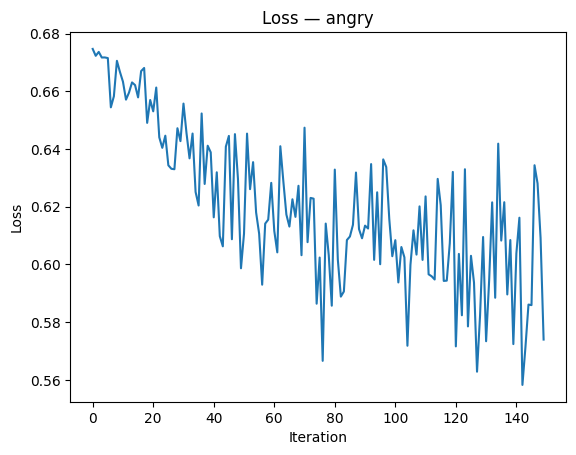

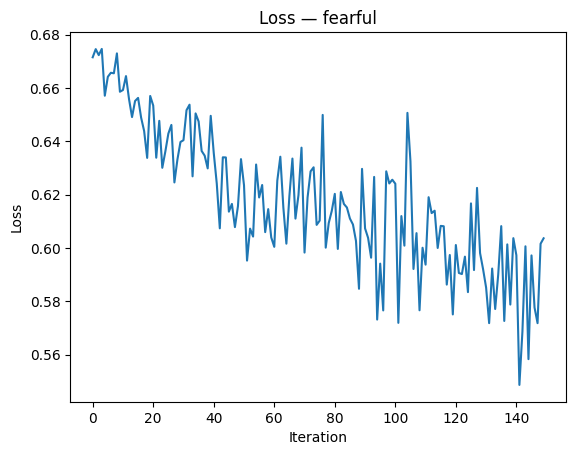

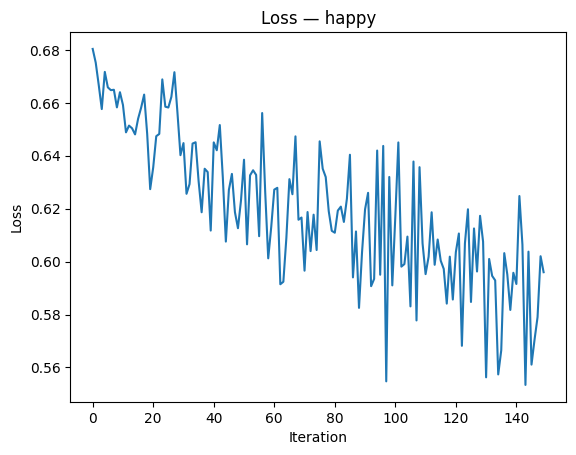

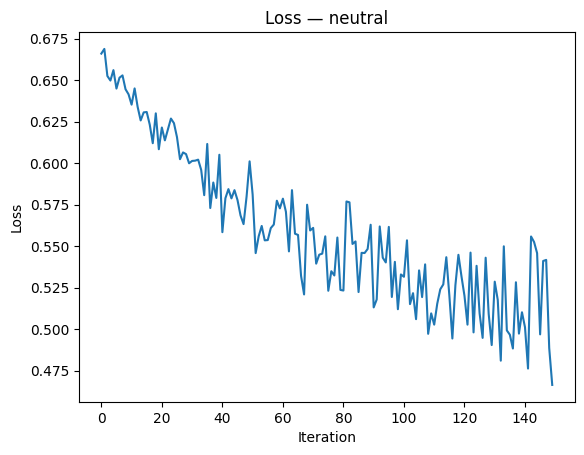

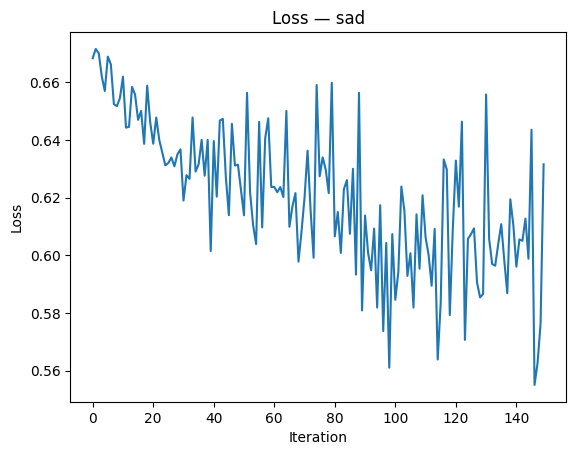

In [28]:

import numpy as np
for cls in ALL_CLASSES:
    path = OUT_DIR / cls / "losses.txt"
    if path.exists():
        losses = np.loadtxt(path)
        plt.figure()
        plt.plot(losses)
        plt.xlabel("Iteration"); plt.ylabel("Loss"); plt.title(f"Loss — {cls}")
        plt.show()


## (Optional) Inference helper

In [29]:

def load_all_models(classes):
    models = {}
    for cls in classes:
        theta, w, b = load_class_params(cls)
        models[cls] = (theta, w, b)
    with open(OUT_DIR / "angle_scales.json", "r") as f:
        scales = json.load(f)
    return models, scales

def scale_single(sample_pc, scales):
    # sample_pc = dict(PC1=..., PC2=..., PC3=...)
    vec = np.array([sample_pc["PC1"], sample_pc["PC2"], sample_pc["PC3"]], dtype=np.float32)
    for j, key in enumerate(["PC1","PC2","PC3"]):
        d = scales[key]["denom"]; c = scales[key]["clip"]
        vec[j] = float(np.clip((vec[j] / d) * c, -c, c))
    return vec

def predict_one(sample_pc):
    models, scales = load_all_models(ALL_CLASSES)
    x_angle = scale_single(sample_pc, scales)
    probs = {}
    for cls, (theta, w, b) in models.items():
        ev = vqc_qnode(x_angle, theta)
        probs[cls] = float(1/(1+np.exp(-(w*ev+b))))
    pred = max(probs, key=probs.get)
    return pred, probs

# Example usage (uncomment & edit PC values):
# sample = {"PC1": 0.2, "PC2": -0.4, "PC3": 0.1}
# label, scores = predict_one(sample); label, scores


CIRCUIT VISUALIZATION

0: ──RY(0.21)───RY(0.00)──RZ(0.00)─╭●────╭X──RY(0.00)──RZ(0.00)─╭●────╭X─┤  <Z>
1: ──RY(0.12)───RY(0.00)──RZ(0.00)─╰X─╭●─│───RY(0.00)──RZ(0.00)─╰X─╭●─│──┤     
2: ──RY(-0.56)──RY(0.00)──RZ(0.00)────╰X─╰●──RY(0.00)──RZ(0.00)────╰X─╰●─┤     


/var/folders/j_/78k8swfs0h5cbxl5zkwdzb400000gn/T/ipykernel_3010/2874105807.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


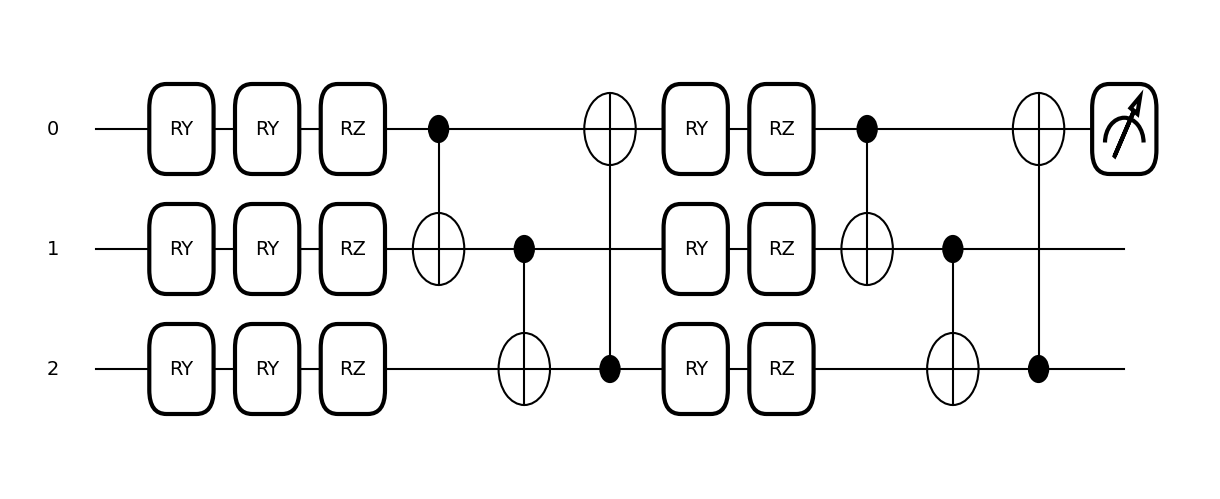

Saved circuit figure → /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/vqc_models_spsa/circuit_vqc.png
resources           : wires: 3
gates: 21
depth: 11
shots: Shots(total=None)
gate_types:
{'RY': 9, 'RZ': 6, 'CNOT': 6}
gate_sizes:
{1: 15, 2: 6}
errors              : {}
num_observables     : 1
num_diagonalizing_gates: 0
num_trainable_params: 0
num_device_wires    : 3
device_name         : default.qubit
expansion_strategy  : gradient
gradient_options    : {}
interface           : auto
diff_method         : best
gradient_fn         : backprop


In [30]:
# --- Circuit visualization (ASCII + Matplotlib) ---

import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pathlib import Path

# Pick a sample input (angles already in radians from your scaling)
try:
    sample_angles = X_train[0]
except NameError:
    sample_angles = np.zeros(N_QUBITS, dtype=float)

# Pick parameters to visualize:
#   option A: zeros (shows the structure)
theta_vis = np.zeros((LAYERS, N_QUBITS, 2), dtype=float)

#   option B: use trained params from a class (uncomment one)
# import numpy as onp
# with np.load(OUT_DIR / "angry" / "params.npz", allow_pickle=True) as d:
#     theta_vis = onp.asarray(d["theta"])

# 1) ASCII diagram (nice for quick inspection)
drawer = qml.draw(vqc_qnode, expansion_strategy="device", decimals=2)
print(drawer(sample_angles, theta_vis))

# 2) Matplotlib diagram (saves a figure)
fig, ax = qml.draw_mpl(vqc_qnode, expansion_strategy="device")(sample_angles, theta_vis)
fig.set_size_inches(12, 3 + 0.6 * N_QUBITS)
plt.tight_layout()
save_path = Path(OUT_DIR) / "circuit_vqc.png"
fig.savefig(save_path, dpi=200)
plt.show()
print("Saved circuit figure →", save_path.resolve())

# 3) Resource summary (gate counts, depth, etc.)
specs = qml.specs(vqc_qnode)(sample_angles, theta_vis)
for k, v in specs.items():
    print(f"{k:20s}: {v}")
